In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 1


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                        | 0/60000 [00:00<?, ?it/s]

 10%|█████████▍                                                                                | 6267/60000 [00:00<00:00, 62657.81it/s]

 22%|███████████████████▎                                                                     | 13056/60000 [00:00<00:00, 65731.67it/s]

 33%|█████████████████████████████▍                                                           | 19861/60000 [00:00<00:00, 66786.15it/s]

 44%|███████████████████████████████████████▍                                                 | 26603/60000 [00:00<00:00, 67034.44it/s]

 56%|█████████████████████████████████████████████████▌                                       | 33398/60000 [00:00<00:00, 67364.02it/s]

 67%|███████████████████████████████████████████████████████████▌                             | 40163/60000 [00:00<00:00, 67459.30it/s]

 78%|█████████████████████████████████████████████████████████████████████▌                   | 46909/60000 [00:00<00:00, 67235.26it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▌         | 53650/60000 [00:00<00:00, 67289.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 66922.52it/s]

  0%|                                                                                                        | 0/10000 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 6633/10000 [00:00<00:00, 66327.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 65768.24it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

1 c6sohudf


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                          | 0/666 [00:00<?, ?it/s]

  0%|▏                                                                                                 | 1/666 [00:00<08:35,  1.29it/s]

  1%|▌                                                                                                 | 4/666 [00:00<01:56,  5.70it/s]

  1%|█▏                                                                                                | 8/666 [00:01<00:57, 11.48it/s]

  2%|█▋                                                                                               | 12/666 [00:01<00:39, 16.55it/s]

  2%|██▎                                                                                              | 16/666 [00:01<00:31, 20.90it/s]

  3%|██▉                                                                                              | 20/666 [00:01<00:26, 24.41it/s]

  4%|███▍                                                                                             | 24/666 [00:01<00:23, 27.11it/s]

  4%|████                                                                                             | 28/666 [00:01<00:21, 29.18it/s]

  5%|████▋                                                                                            | 32/666 [00:01<00:20, 30.70it/s]

  5%|█████▏                                                                                           | 36/666 [00:01<00:19, 31.79it/s]

  6%|█████▊                                                                                           | 40/666 [00:01<00:19, 32.62it/s]

  7%|██████▍                                                                                          | 44/666 [00:02<00:18, 33.07it/s]

  7%|██████▉                                                                                          | 48/666 [00:02<00:18, 33.56it/s]

  8%|███████▌                                                                                         | 52/666 [00:02<00:18, 33.90it/s]

  8%|████████▏                                                                                        | 56/666 [00:02<00:17, 34.12it/s]

  9%|████████▋                                                                                        | 60/666 [00:02<00:17, 34.24it/s]

 10%|█████████▎                                                                                       | 64/666 [00:02<00:17, 34.33it/s]

 10%|█████████▉                                                                                       | 68/666 [00:02<00:17, 34.38it/s]

 11%|██████████▍                                                                                      | 72/666 [00:02<00:17, 34.42it/s]

 11%|███████████                                                                                      | 76/666 [00:02<00:17, 34.48it/s]

 12%|███████████▋                                                                                     | 80/666 [00:03<00:17, 34.46it/s]

 13%|████████████▏                                                                                    | 84/666 [00:03<00:16, 34.51it/s]

 13%|████████████▊                                                                                    | 88/666 [00:03<00:16, 34.32it/s]

 14%|█████████████▍                                                                                   | 92/666 [00:03<00:16, 34.35it/s]

 14%|█████████████▉                                                                                   | 96/666 [00:03<00:16, 34.39it/s]

 15%|██████████████▍                                                                                 | 100/666 [00:03<00:16, 34.20it/s]

 16%|██████████████▉                                                                                 | 104/666 [00:03<00:16, 34.24it/s]

 16%|███████████████▌                                                                                | 108/666 [00:03<00:16, 34.35it/s]

 17%|████████████████▏                                                                               | 112/666 [00:04<00:16, 34.45it/s]

 17%|████████████████▋                                                                               | 116/666 [00:04<00:15, 34.46it/s]

 18%|█████████████████▎                                                                              | 120/666 [00:04<00:15, 34.44it/s]

 19%|█████████████████▊                                                                              | 124/666 [00:04<00:15, 34.43it/s]

 19%|██████████████████▍                                                                             | 128/666 [00:04<00:15, 34.49it/s]

 20%|███████████████████                                                                             | 132/666 [00:04<00:15, 34.50it/s]

 20%|███████████████████▌                                                                            | 136/666 [00:04<00:15, 34.46it/s]

 21%|████████████████████▏                                                                           | 140/666 [00:04<00:15, 34.47it/s]

 22%|████████████████████▊                                                                           | 144/666 [00:04<00:15, 34.46it/s]

 22%|█████████████████████▎                                                                          | 148/666 [00:05<00:15, 34.47it/s]

 23%|█████████████████████▉                                                                          | 152/666 [00:05<00:14, 34.45it/s]

 23%|██████████████████████▍                                                                         | 156/666 [00:05<00:14, 34.45it/s]

 24%|███████████████████████                                                                         | 160/666 [00:05<00:14, 34.42it/s]

 25%|███████████████████████▋                                                                        | 164/666 [00:05<00:14, 34.48it/s]

 25%|████████████████████████▏                                                                       | 168/666 [00:05<00:14, 34.41it/s]

 26%|████████████████████████▊                                                                       | 172/666 [00:05<00:14, 34.24it/s]

 26%|█████████████████████████▎                                                                      | 176/666 [00:05<00:14, 34.06it/s]

 27%|█████████████████████████▉                                                                      | 180/666 [00:06<00:14, 33.97it/s]

 28%|██████████████████████████▌                                                                     | 184/666 [00:06<00:14, 33.88it/s]

 28%|███████████████████████████                                                                     | 188/666 [00:06<00:14, 33.82it/s]

 29%|███████████████████████████▋                                                                    | 192/666 [00:06<00:14, 33.54it/s]

 29%|████████████████████████████▎                                                                   | 196/666 [00:06<00:14, 33.25it/s]

 30%|████████████████████████████▊                                                                   | 200/666 [00:06<00:13, 33.53it/s]

 31%|█████████████████████████████▍                                                                  | 204/666 [00:06<00:13, 33.70it/s]

 31%|█████████████████████████████▉                                                                  | 208/666 [00:06<00:13, 33.92it/s]

 32%|██████████████████████████████▌                                                                 | 212/666 [00:06<00:13, 34.07it/s]

 32%|███████████████████████████████▏                                                                | 216/666 [00:07<00:13, 34.19it/s]

 33%|███████████████████████████████▋                                                                | 220/666 [00:07<00:13, 34.27it/s]

 34%|████████████████████████████████▎                                                               | 224/666 [00:07<00:12, 34.36it/s]

 34%|████████████████████████████████▊                                                               | 228/666 [00:07<00:12, 34.39it/s]

 35%|█████████████████████████████████▍                                                              | 232/666 [00:07<00:12, 34.44it/s]

 35%|██████████████████████████████████                                                              | 236/666 [00:07<00:12, 34.43it/s]

 36%|██████████████████████████████████▌                                                             | 240/666 [00:07<00:12, 34.43it/s]

 37%|███████████████████████████████████▏                                                            | 244/666 [00:07<00:12, 34.20it/s]

 37%|███████████████████████████████████▋                                                            | 248/666 [00:07<00:12, 34.33it/s]

 38%|████████████████████████████████████▎                                                           | 252/666 [00:08<00:12, 34.27it/s]

 38%|████████████████████████████████████▉                                                           | 256/666 [00:08<00:11, 34.33it/s]

 39%|█████████████████████████████████████▍                                                          | 260/666 [00:08<00:11, 34.37it/s]

 40%|██████████████████████████████████████                                                          | 264/666 [00:08<00:11, 34.40it/s]

 40%|██████████████████████████████████████▋                                                         | 268/666 [00:08<00:11, 34.39it/s]

 41%|███████████████████████████████████████▏                                                        | 272/666 [00:08<00:11, 34.40it/s]

 41%|███████████████████████████████████████▊                                                        | 276/666 [00:08<00:11, 34.45it/s]

 42%|████████████████████████████████████████▎                                                       | 280/666 [00:08<00:11, 34.35it/s]

 43%|████████████████████████████████████████▉                                                       | 284/666 [00:09<00:11, 34.42it/s]

 43%|█████████████████████████████████████████▌                                                      | 288/666 [00:09<00:10, 34.50it/s]

 44%|██████████████████████████████████████████                                                      | 292/666 [00:09<00:10, 34.45it/s]

 44%|██████████████████████████████████████████▋                                                     | 296/666 [00:09<00:10, 34.47it/s]

 45%|███████████████████████████████████████████▏                                                    | 300/666 [00:09<00:10, 34.51it/s]

 46%|███████████████████████████████████████████▊                                                    | 304/666 [00:09<00:10, 34.48it/s]

 46%|████████████████████████████████████████████▍                                                   | 308/666 [00:09<00:10, 34.25it/s]

 47%|████████████████████████████████████████████▉                                                   | 312/666 [00:09<00:10, 34.31it/s]

 47%|█████████████████████████████████████████████▌                                                  | 316/666 [00:09<00:10, 34.37it/s]

 48%|██████████████████████████████████████████████▏                                                 | 320/666 [00:10<00:10, 34.40it/s]

 49%|██████████████████████████████████████████████▋                                                 | 324/666 [00:10<00:09, 34.40it/s]

 49%|███████████████████████████████████████████████▎                                                | 328/666 [00:10<00:09, 34.39it/s]

 50%|███████████████████████████████████████████████▊                                                | 332/666 [00:10<00:09, 34.38it/s]

 50%|████████████████████████████████████████████████▍                                               | 336/666 [00:10<00:09, 34.36it/s]

 51%|█████████████████████████████████████████████████                                               | 340/666 [00:10<00:09, 34.41it/s]

 52%|█████████████████████████████████████████████████▌                                              | 344/666 [00:10<00:09, 34.37it/s]

 52%|██████████████████████████████████████████████████▏                                             | 348/666 [00:10<00:09, 34.40it/s]

 53%|██████████████████████████████████████████████████▋                                             | 352/666 [00:11<00:09, 34.43it/s]

 53%|███████████████████████████████████████████████████▎                                            | 356/666 [00:11<00:08, 34.46it/s]

 54%|███████████████████████████████████████████████████▉                                            | 360/666 [00:11<00:08, 34.40it/s]

 55%|████████████████████████████████████████████████████▍                                           | 364/666 [00:11<00:08, 34.44it/s]

 55%|█████████████████████████████████████████████████████                                           | 368/666 [00:11<00:08, 34.56it/s]

 56%|█████████████████████████████████████████████████████▌                                          | 372/666 [00:11<00:08, 34.50it/s]

 56%|██████████████████████████████████████████████████████▏                                         | 376/666 [00:11<00:08, 34.49it/s]

 57%|██████████████████████████████████████████████████████▊                                         | 380/666 [00:11<00:08, 34.46it/s]

 58%|███████████████████████████████████████████████████████▎                                        | 384/666 [00:11<00:08, 34.46it/s]

 58%|███████████████████████████████████████████████████████▉                                        | 388/666 [00:12<00:08, 34.44it/s]

 59%|████████████████████████████████████████████████████████▌                                       | 392/666 [00:12<00:07, 34.46it/s]

 59%|█████████████████████████████████████████████████████████                                       | 396/666 [00:12<00:07, 34.46it/s]

 60%|█████████████████████████████████████████████████████████▋                                      | 400/666 [00:12<00:07, 34.41it/s]

 61%|██████████████████████████████████████████████████████████▏                                     | 404/666 [00:12<00:07, 34.46it/s]

 61%|██████████████████████████████████████████████████████████▊                                     | 408/666 [00:12<00:07, 34.44it/s]

 62%|███████████████████████████████████████████████████████████▍                                    | 412/666 [00:12<00:07, 33.46it/s]

 62%|███████████████████████████████████████████████████████████▉                                    | 416/666 [00:12<00:07, 33.70it/s]

 63%|████████████████████████████████████████████████████████████▌                                   | 420/666 [00:13<00:07, 34.06it/s]

 64%|█████████████████████████████████████████████████████████████                                   | 424/666 [00:13<00:07, 34.24it/s]

 64%|█████████████████████████████████████████████████████████████▋                                  | 428/666 [00:13<00:06, 34.42it/s]

 65%|██████████████████████████████████████████████████████████████▎                                 | 432/666 [00:13<00:06, 34.48it/s]

 65%|██████████████████████████████████████████████████████████████▊                                 | 436/666 [00:13<00:06, 34.54it/s]

 66%|███████████████████████████████████████████████████████████████▍                                | 440/666 [00:13<00:06, 34.62it/s]

 67%|████████████████████████████████████████████████████████████████                                | 444/666 [00:13<00:06, 34.63it/s]

 67%|████████████████████████████████████████████████████████████████▌                               | 448/666 [00:13<00:06, 34.30it/s]

 68%|█████████████████████████████████████████████████████████████████▏                              | 452/666 [00:13<00:06, 34.43it/s]

 68%|█████████████████████████████████████████████████████████████████▋                              | 456/666 [00:14<00:06, 34.57it/s]

 69%|██████████████████████████████████████████████████████████████████▎                             | 460/666 [00:14<00:05, 34.63it/s]

 70%|██████████████████████████████████████████████████████████████████▉                             | 464/666 [00:14<00:05, 34.71it/s]

 70%|███████████████████████████████████████████████████████████████████▍                            | 468/666 [00:14<00:05, 34.70it/s]

 71%|████████████████████████████████████████████████████████████████████                            | 472/666 [00:14<00:05, 34.69it/s]

 71%|████████████████████████████████████████████████████████████████████▌                           | 476/666 [00:14<00:05, 34.68it/s]

 72%|█████████████████████████████████████████████████████████████████████▏                          | 480/666 [00:14<00:05, 34.60it/s]

 73%|█████████████████████████████████████████████████████████████████████▊                          | 484/666 [00:14<00:05, 34.69it/s]

 73%|██████████████████████████████████████████████████████████████████████▎                         | 488/666 [00:14<00:05, 34.69it/s]

 74%|██████████████████████████████████████████████████████████████████████▉                         | 492/666 [00:15<00:05, 34.74it/s]

 74%|███████████████████████████████████████████████████████████████████████▍                        | 496/666 [00:15<00:04, 34.73it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 500/666 [00:15<00:04, 34.58it/s]

 76%|████████████████████████████████████████████████████████████████████████▋                       | 504/666 [00:15<00:04, 34.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████▏                      | 508/666 [00:15<00:04, 34.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████▊                      | 512/666 [00:15<00:04, 34.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████▍                     | 516/666 [00:15<00:04, 34.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████▉                     | 520/666 [00:15<00:04, 34.38it/s]

 79%|███████████████████████████████████████████████████████████████████████████▌                    | 524/666 [00:16<00:04, 34.34it/s]

 79%|████████████████████████████████████████████████████████████████████████████                    | 528/666 [00:16<00:04, 34.32it/s]

 80%|████████████████████████████████████████████████████████████████████████████▋                   | 532/666 [00:16<00:03, 34.38it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▎                  | 536/666 [00:16<00:03, 34.46it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 540/666 [00:16<00:03, 34.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▍                 | 544/666 [00:16<00:03, 34.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▉                 | 548/666 [00:16<00:03, 34.44it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▌                | 552/666 [00:16<00:03, 34.50it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▏               | 556/666 [00:16<00:03, 34.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▋               | 560/666 [00:17<00:03, 34.60it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▎              | 564/666 [00:17<00:02, 34.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▊              | 568/666 [00:17<00:02, 34.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▍             | 572/666 [00:17<00:02, 34.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████             | 576/666 [00:17<00:02, 34.67it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▌            | 580/666 [00:17<00:02, 34.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▏           | 584/666 [00:17<00:02, 34.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▊           | 588/666 [00:17<00:02, 34.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▎          | 592/666 [00:17<00:02, 34.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▉          | 596/666 [00:18<00:02, 34.45it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 600/666 [00:18<00:01, 34.38it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████         | 604/666 [00:18<00:01, 34.37it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▋        | 608/666 [00:18<00:01, 34.37it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▏       | 612/666 [00:18<00:01, 34.38it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▊       | 616/666 [00:18<00:01, 34.45it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▎      | 620/666 [00:18<00:01, 34.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▉      | 624/666 [00:18<00:01, 34.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 628/666 [00:19<00:01, 34.44it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████     | 632/666 [00:19<00:00, 34.36it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 636/666 [00:19<00:00, 34.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 640/666 [00:19<00:00, 34.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▊   | 644/666 [00:19<00:00, 34.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▍  | 648/666 [00:19<00:00, 34.23it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▉  | 652/666 [00:19<00:00, 34.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▌ | 656/666 [00:19<00:00, 34.35it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 660/666 [00:19<00:00, 34.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████▋| 664/666 [00:20<00:00, 35.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 666/666 [00:20<00:00, 32.96it/s]

train - OK


  0%|                                                                                                          | 0/167 [00:00<?, ?it/s]

  1%|▌                                                                                                 | 1/167 [00:00<00:24,  6.89it/s]

  3%|██▉                                                                                               | 5/167 [00:00<00:07, 21.30it/s]

  5%|█████▎                                                                                            | 9/167 [00:00<00:05, 26.93it/s]

  8%|███████▌                                                                                         | 13/167 [00:00<00:05, 29.64it/s]

 10%|█████████▊                                                                                       | 17/167 [00:00<00:04, 31.28it/s]

 13%|████████████▏                                                                                    | 21/167 [00:00<00:04, 32.26it/s]

 15%|██████████████▌                                                                                  | 25/167 [00:00<00:04, 32.87it/s]

 17%|████████████████▊                                                                                | 29/167 [00:00<00:04, 33.28it/s]

 20%|███████████████████▏                                                                             | 33/167 [00:01<00:04, 33.46it/s]

 22%|█████████████████████▍                                                                           | 37/167 [00:01<00:03, 33.72it/s]

 25%|███████████████████████▊                                                                         | 41/167 [00:01<00:03, 33.87it/s]

 27%|██████████████████████████▏                                                                      | 45/167 [00:01<00:03, 33.96it/s]

 29%|████████████████████████████▍                                                                    | 49/167 [00:01<00:03, 34.02it/s]

 32%|██████████████████████████████▊                                                                  | 53/167 [00:01<00:03, 34.12it/s]

 34%|█████████████████████████████████                                                                | 57/167 [00:01<00:03, 34.14it/s]

 37%|███████████████████████████████████▍                                                             | 61/167 [00:01<00:03, 34.18it/s]

 39%|█████████████████████████████████████▊                                                           | 65/167 [00:02<00:02, 34.27it/s]

 41%|████████████████████████████████████████                                                         | 69/167 [00:02<00:02, 34.29it/s]

 44%|██████████████████████████████████████████▍                                                      | 73/167 [00:02<00:02, 34.23it/s]

 46%|████████████████████████████████████████████▋                                                    | 77/167 [00:02<00:02, 34.33it/s]

 49%|███████████████████████████████████████████████                                                  | 81/167 [00:02<00:02, 34.51it/s]

 51%|█████████████████████████████████████████████████▎                                               | 85/167 [00:02<00:02, 34.53it/s]

 53%|███████████████████████████████████████████████████▋                                             | 89/167 [00:02<00:02, 34.63it/s]

 56%|██████████████████████████████████████████████████████                                           | 93/167 [00:02<00:02, 34.65it/s]

 58%|████████████████████████████████████████████████████████▎                                        | 97/167 [00:02<00:02, 34.32it/s]

 60%|██████████████████████████████████████████████████████████                                      | 101/167 [00:03<00:01, 34.34it/s]

 63%|████████████████████████████████████████████████████████████▎                                   | 105/167 [00:03<00:01, 34.46it/s]

 65%|██████████████████████████████████████████████████████████████▋                                 | 109/167 [00:03<00:01, 34.52it/s]

 68%|████████████████████████████████████████████████████████████████▉                               | 113/167 [00:03<00:01, 34.59it/s]

 70%|███████████████████████████████████████████████████████████████████▎                            | 117/167 [00:03<00:01, 34.64it/s]

 72%|█████████████████████████████████████████████████████████████████████▌                          | 121/167 [00:03<00:01, 34.72it/s]

 75%|███████████████████████████████████████████████████████████████████████▊                        | 125/167 [00:03<00:01, 34.61it/s]

 77%|██████████████████████████████████████████████████████████████████████████▏                     | 129/167 [00:03<00:01, 34.50it/s]

 80%|████████████████████████████████████████████████████████████████████████████▍                   | 133/167 [00:03<00:00, 34.44it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▊                 | 137/167 [00:04<00:00, 34.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████               | 141/167 [00:04<00:00, 34.62it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▎            | 145/167 [00:04<00:00, 34.66it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▋          | 149/167 [00:04<00:00, 34.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▉        | 153/167 [00:04<00:00, 34.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▎     | 157/167 [00:04<00:00, 34.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▌   | 161/167 [00:04<00:00, 34.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▊ | 165/167 [00:04<00:00, 35.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:05<00:00, 33.36it/s]

val - OK


  0%|                                                                                                          | 0/139 [00:00<?, ?it/s]

  1%|▋                                                                                                 | 1/139 [00:00<00:19,  6.94it/s]

  4%|███▌                                                                                              | 5/139 [00:00<00:06, 21.43it/s]

  6%|██████▎                                                                                           | 9/139 [00:00<00:04, 26.99it/s]

  9%|█████████                                                                                        | 13/139 [00:00<00:04, 29.81it/s]

 12%|███████████▊                                                                                     | 17/139 [00:00<00:03, 31.37it/s]

 15%|██████████████▋                                                                                  | 21/139 [00:00<00:03, 32.39it/s]

 18%|█████████████████▍                                                                               | 25/139 [00:00<00:03, 32.95it/s]

 21%|████████████████████▏                                                                            | 29/139 [00:00<00:03, 33.38it/s]

 24%|███████████████████████                                                                          | 33/139 [00:01<00:03, 33.63it/s]

 27%|█████████████████████████▊                                                                       | 37/139 [00:01<00:03, 33.91it/s]

 29%|████████████████████████████▌                                                                    | 41/139 [00:01<00:02, 34.07it/s]

 32%|███████████████████████████████▍                                                                 | 45/139 [00:01<00:02, 34.05it/s]

 35%|██████████████████████████████████▏                                                              | 49/139 [00:01<00:02, 33.75it/s]

 38%|████████████████████████████████████▉                                                            | 53/139 [00:01<00:02, 33.77it/s]

 41%|███████████████████████████████████████▊                                                         | 57/139 [00:01<00:02, 33.89it/s]

 44%|██████████████████████████████████████████▌                                                      | 61/139 [00:01<00:02, 33.92it/s]

 47%|█████████████████████████████████████████████▎                                                   | 65/139 [00:02<00:02, 33.97it/s]

 50%|████████████████████████████████████████████████▏                                                | 69/139 [00:02<00:02, 34.03it/s]

 53%|██████████████████████████████████████████████████▉                                              | 73/139 [00:02<00:01, 34.11it/s]

 55%|█████████████████████████████████████████████████████▋                                           | 77/139 [00:02<00:01, 34.25it/s]

 58%|████████████████████████████████████████████████████████▌                                        | 81/139 [00:02<00:01, 34.27it/s]

 61%|███████████████████████████████████████████████████████████▎                                     | 85/139 [00:02<00:01, 34.29it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 89/139 [00:02<00:01, 34.30it/s]

 67%|████████████████████████████████████████████████████████████████▉                                | 93/139 [00:02<00:01, 34.25it/s]

 70%|███████████████████████████████████████████████████████████████████▋                             | 97/139 [00:02<00:01, 34.29it/s]

 73%|█████████████████████████████████████████████████████████████████████▊                          | 101/139 [00:03<00:01, 34.22it/s]

 76%|████████████████████████████████████████████████████████████████████████▌                       | 105/139 [00:03<00:00, 34.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████▎                    | 109/139 [00:03<00:00, 34.28it/s]

 81%|██████████████████████████████████████████████████████████████████████████████                  | 113/139 [00:03<00:00, 34.22it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▊               | 117/139 [00:03<00:00, 33.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▌            | 121/139 [00:03<00:00, 33.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▎         | 125/139 [00:03<00:00, 33.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████       | 129/139 [00:03<00:00, 33.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▊    | 133/139 [00:04<00:00, 34.35it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▌ | 137/139 [00:04<00:00, 35.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 32.89it/s]

test InD - OK


  0%|                                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▊                                                                                                 | 1/124 [00:00<00:17,  6.97it/s]

  4%|███▉                                                                                              | 5/124 [00:00<00:05, 21.24it/s]

  7%|███████                                                                                           | 9/124 [00:00<00:04, 26.84it/s]

 10%|██████████▏                                                                                      | 13/124 [00:00<00:03, 29.56it/s]

 14%|█████████████▎                                                                                   | 17/124 [00:00<00:03, 31.20it/s]

 17%|████████████████▍                                                                                | 21/124 [00:00<00:03, 32.19it/s]

 20%|███████████████████▌                                                                             | 25/124 [00:00<00:03, 32.73it/s]

 23%|██████████████████████▋                                                                          | 29/124 [00:00<00:02, 33.20it/s]

 27%|█████████████████████████▊                                                                       | 33/124 [00:01<00:02, 33.37it/s]

 30%|████████████████████████████▉                                                                    | 37/124 [00:01<00:02, 33.55it/s]

 33%|████████████████████████████████                                                                 | 41/124 [00:01<00:02, 33.60it/s]

 36%|███████████████████████████████████▏                                                             | 45/124 [00:01<00:02, 33.78it/s]

 40%|██████████████████████████████████████▎                                                          | 49/124 [00:01<00:02, 33.90it/s]

 43%|█████████████████████████████████████████▍                                                       | 53/124 [00:01<00:02, 34.06it/s]

 46%|████████████████████████████████████████████▌                                                    | 57/124 [00:01<00:01, 34.08it/s]

 49%|███████████████████████████████████████████████▋                                                 | 61/124 [00:01<00:01, 34.15it/s]

 52%|██████████████████████████████████████████████████▊                                              | 65/124 [00:02<00:01, 34.20it/s]

 56%|█████████████████████████████████████████████████████▉                                           | 69/124 [00:02<00:01, 34.25it/s]

 59%|█████████████████████████████████████████████████████████                                        | 73/124 [00:02<00:01, 34.18it/s]

 62%|████████████████████████████████████████████████████████████▏                                    | 77/124 [00:02<00:01, 34.18it/s]

 65%|███████████████████████████████████████████████████████████████▎                                 | 81/124 [00:02<00:01, 34.24it/s]

 69%|██████████████████████████████████████████████████████████████████▍                              | 85/124 [00:02<00:01, 34.23it/s]

 72%|█████████████████████████████████████████████████████████████████████▌                           | 89/124 [00:02<00:01, 34.26it/s]

 75%|████████████████████████████████████████████████████████████████████████▊                        | 93/124 [00:02<00:00, 34.27it/s]

 78%|███████████████████████████████████████████████████████████████████████████▉                     | 97/124 [00:02<00:00, 34.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▏                 | 101/124 [00:03<00:00, 34.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▎              | 105/124 [00:03<00:00, 34.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 109/124 [00:03<00:00, 34.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▍        | 113/124 [00:03<00:00, 34.17it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 117/124 [00:03<00:00, 34.33it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▋  | 121/124 [00:03<00:00, 35.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:03<00:00, 32.75it/s]

test OoD - OK


  0%|                                                                                                          | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                              | 4/100 [00:00<00:02, 37.79it/s]

  8%|███████▊                                                                                          | 8/100 [00:00<00:02, 38.44it/s]

 12%|███████████▋                                                                                     | 12/100 [00:00<00:02, 38.72it/s]

 16%|███████████████▌                                                                                 | 16/100 [00:00<00:02, 38.78it/s]

 20%|███████████████████▍                                                                             | 20/100 [00:00<00:02, 38.96it/s]

 24%|███████████████████████▎                                                                         | 24/100 [00:00<00:01, 38.98it/s]

 28%|███████████████████████████▏                                                                     | 28/100 [00:00<00:01, 39.04it/s]

 32%|███████████████████████████████                                                                  | 32/100 [00:00<00:01, 39.01it/s]

 36%|██████████████████████████████████▉                                                              | 36/100 [00:00<00:01, 39.05it/s]

 40%|██████████████████████████████████████▊                                                          | 40/100 [00:01<00:01, 39.07it/s]

 44%|██████████████████████████████████████████▋                                                      | 44/100 [00:01<00:01, 39.11it/s]

 48%|██████████████████████████████████████████████▌                                                  | 48/100 [00:01<00:01, 39.10it/s]

 52%|██████████████████████████████████████████████████▍                                              | 52/100 [00:01<00:01, 39.09it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 56/100 [00:01<00:01, 39.03it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 60/100 [00:01<00:01, 39.03it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 64/100 [00:01<00:00, 39.00it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 68/100 [00:01<00:00, 39.07it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 72/100 [00:01<00:00, 39.09it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 76/100 [00:01<00:00, 39.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 80/100 [00:02<00:00, 39.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 84/100 [00:02<00:00, 39.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 88/100 [00:02<00:00, 39.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 92/100 [00:02<00:00, 39.08it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [00:02<00:00, 39.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.99it/s]

test RnD - OK
(42606,) (42606,)
(10652,) (10652,)
(8865,) (8865,)
(7877,) (7877,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.980307 0.40326226
7.968577 0.39553288
7.99294 0.40134552
7.508904 0.24491869
15.528645 0.8590267
14.564561 0.01761662
14.564959 0.017875524
14.564349 0.017656961
14.560748 0.015675677
30.871437 0.6916888


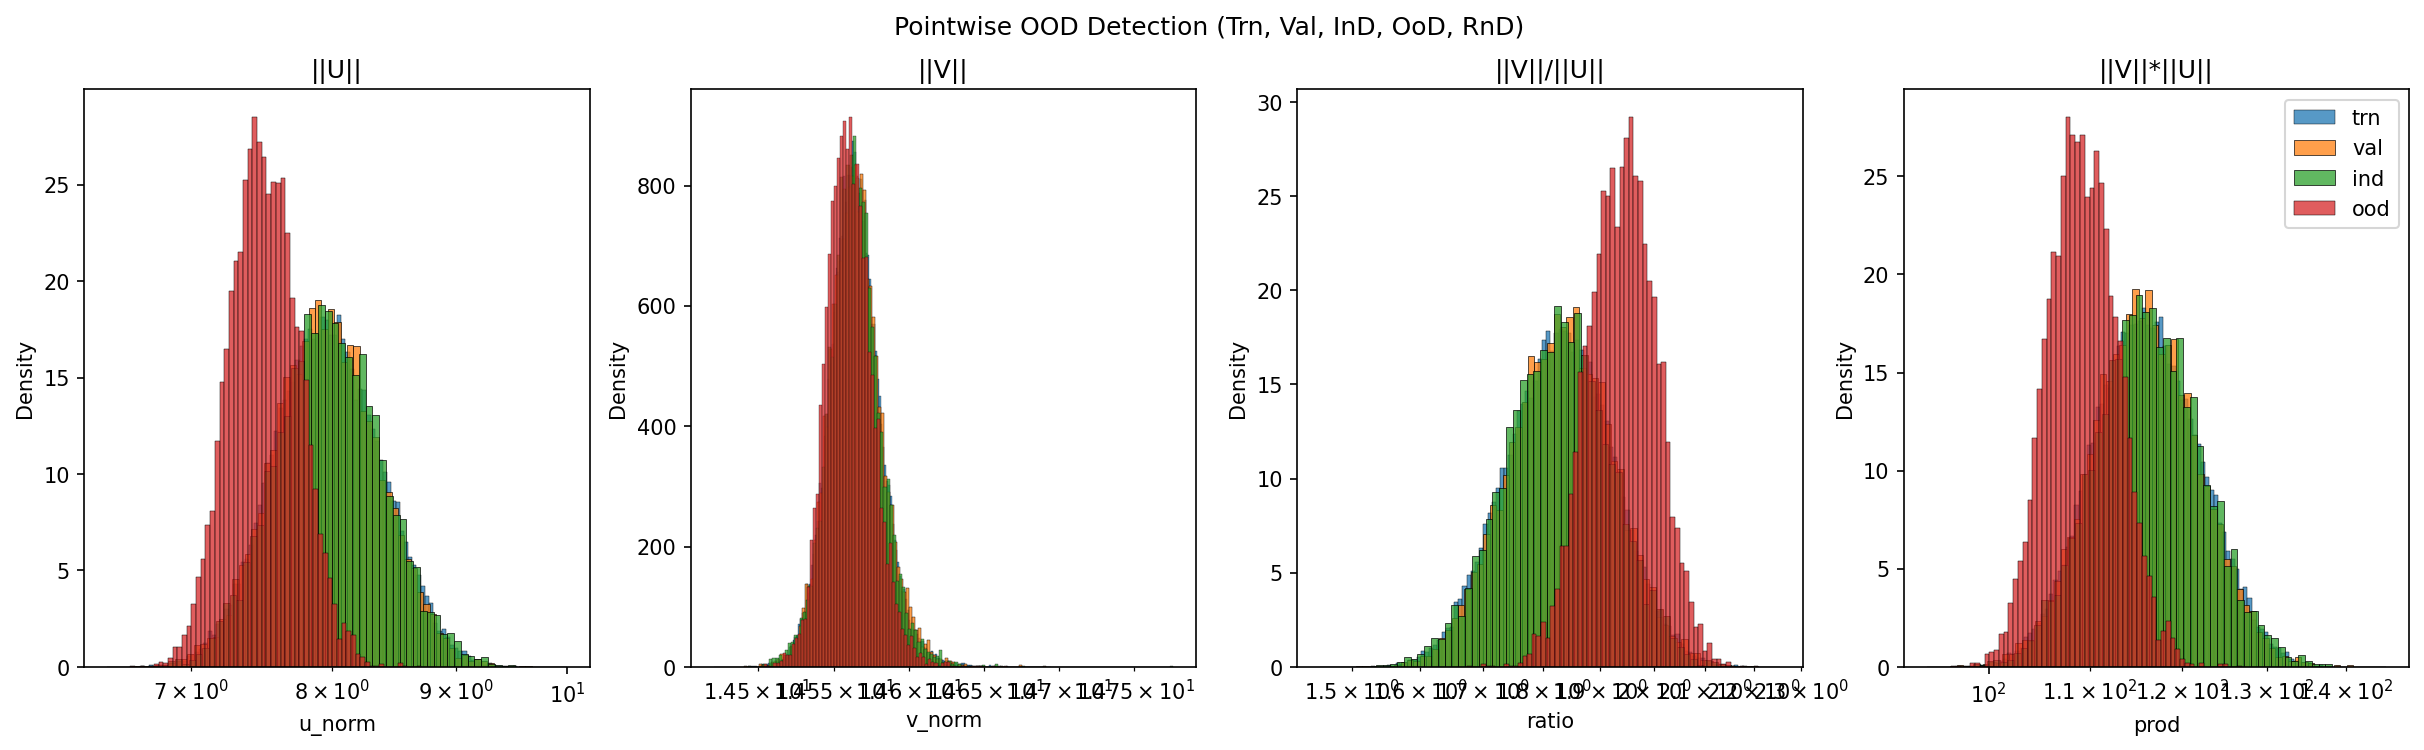

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 14.471053 14.694529 0.22347546
Val 14.490764 14.691404 0.20064068
Ind 14.493365 14.776605 0.28323936
Ood 14.504288 14.665473 0.16118526
Rnd 28.252169 33.738697 5.4865284
KstestResult(statistic=0.10074060994616825, pvalue=2.7220997194168897e-37, statistic_location=14.562662, statistic_sign=-1)


[6, 1, 0, 3, 8, 4, 5, 2, 7, 9]


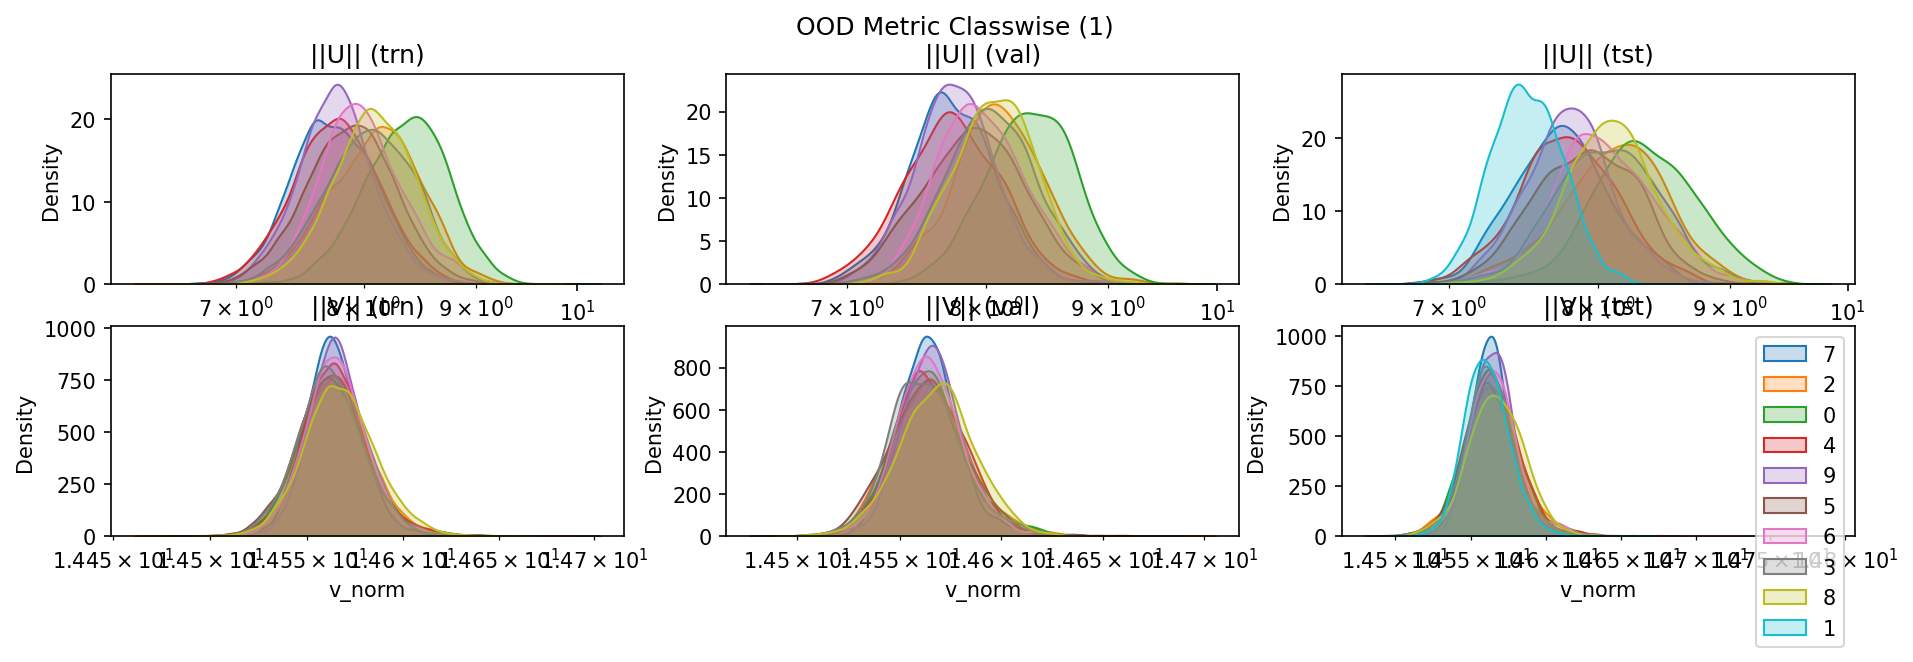

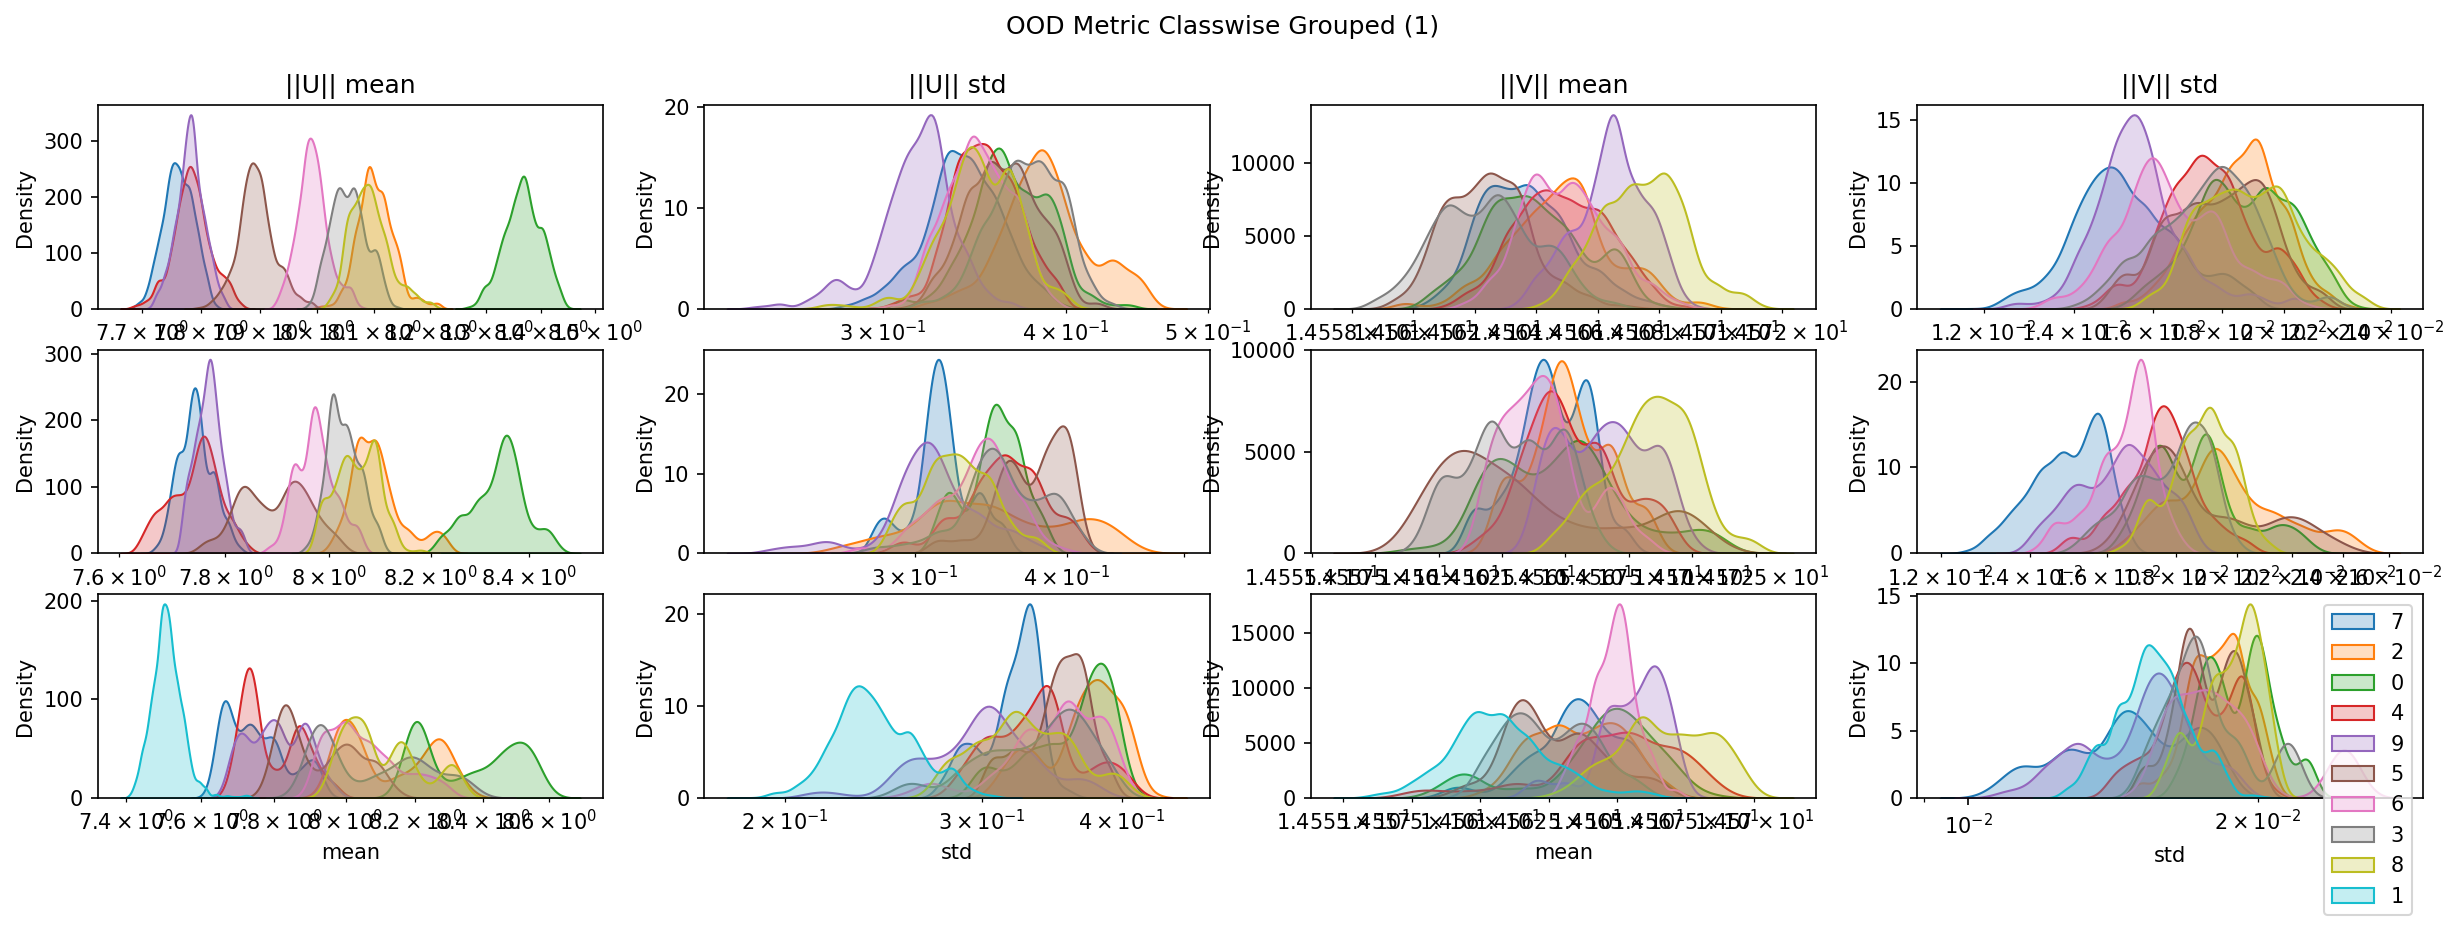

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
all_targets = list(data_tst['target'].unique())
print(all_targets)

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in all_targets:
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in all_targets:
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in all_targets:
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)